Explore PolarRNN interpretation on Rossmann data

In [2]:
import os, torch, yaml
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from configs.defaults import dataset_defaults, model_defaults, Globs
from data.loader import data_loader
from train.trainer import select_trainer
from models.metrics import NRMSE, ND
from helpers.wandb_common import restore_wandb_cloud
# model_name, dataset_name = 'polar_dense', 'synthetic'

# config = dict(MODEL=model_name, DATASET=dataset_name)
# config.update(dataset_defaults[dataset_name])
# config.update(model_defaults[model_name])
save_dir = 'reports/figures'

In [3]:
model_id = '3r5uvsl1' 
# file_paths = restore_wandb_cloud(model_id, Globs.project_name, Globs.entity_name,
#                     data_path=f'wandb/{model_id}',
#                     files_names=['config.yaml'])
model_path = os.path.join('models', model_id, 'model.ckpt')
# Restore config as a dict
config = yaml.load(open(os.path.join(f'wandb/{model_id}', 'config.yaml')), Loader=yaml.FullLoader)
for k in list(config.keys()):
    if type(config[k]) is dict and 'value' in config[k]:
        config[k] = config[k]['value']

In [4]:
config['MODEL'], config['DATASET']

('polar_rnn', 'rossmann')

In [6]:
dataset_formatter = data_loader(config['DATASET'])(config)
training, train_loader, val_loader = dataset_formatter.load_dataset()

In [7]:
trainer = select_trainer(config['MODEL'])(config, logger=None)
trainer.build_model(training)
trainer.load_from_checkpoint(model_path)
model = trainer.model

Number of parameters in the network: 194.5


/home/ozan/.conda/envs/exp_ts/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/ozan/.conda/envs/exp_ts/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [9]:
actuals = torch.cat([y[0] for x, y in iter(val_loader)])
predictions, x = model.predict(val_loader, n_samples=None, return_x=True)
print(NRMSE().loss(predictions, actuals), ND().loss(predictions, actuals))

tensor(0.1553) tensor(0.1112)


In [10]:
raw_predictions, x = model.predict(val_loader, mode="raw", return_x=True, n_samples=None, interpret=True)

In [11]:
model._interpret_dict.keys()

dict_keys(['embedding_sizes', 'x_categoricals', 'x_reals', 'encoder_input_vector', 'alpha_out', 'beta_out', 'encoder_context', '0_merged_context', '0_output', '0_W', '0_b', '1_merged_context', '1_output', '1_W', '1_b', '2_merged_context', '2_output', '2_W', '2_b', '3_merged_context', '3_output', '3_W', '3_b', '4_merged_context', '4_output', '4_W', '4_b', '5_merged_context', '5_output', '5_W', '5_b', '6_merged_context', '6_output', '6_W', '6_b', '7_merged_context', '7_output', '7_W', '7_b', '8_merged_context', '8_output', '8_W', '8_b', '9_merged_context', '9_output', '9_W', '9_b', '10_merged_context', '10_output', '10_W', '10_b', '11_merged_context', '11_output', '11_W', '11_b', '12_merged_context', '12_output', '12_W', '12_b', '13_merged_context', '13_output', '13_W', '13_b', '14_merged_context', '14_output', '14_W', '14_b', '15_merged_context', '15_output', '15_W', '15_b', '16_merged_context', '16_output', '16_W', '16_b', '17_merged_context', '17_output', '17_W', '17_b', '18_merged_co

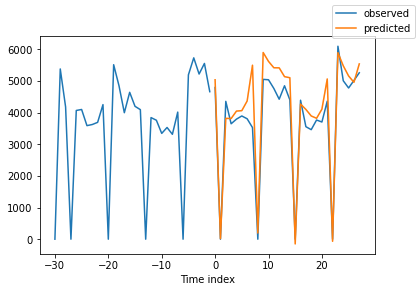

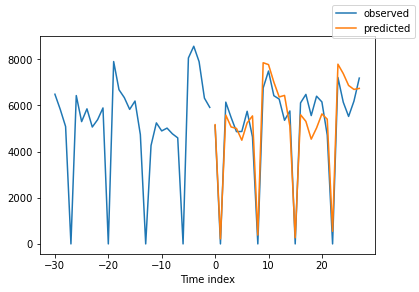

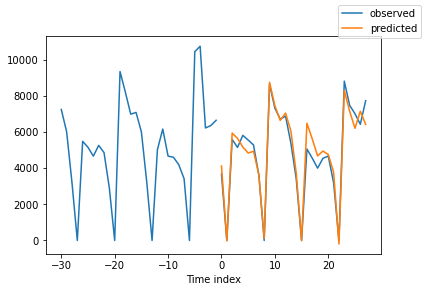

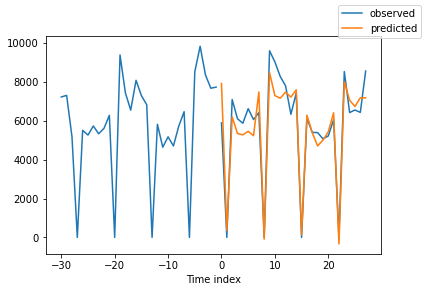

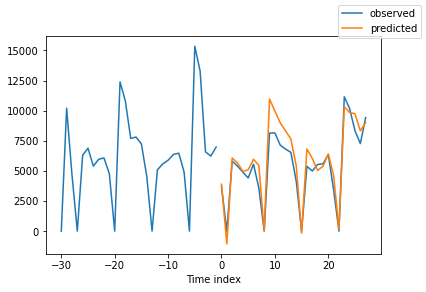

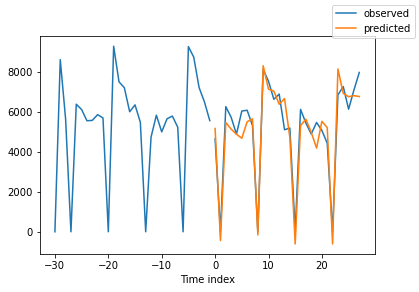

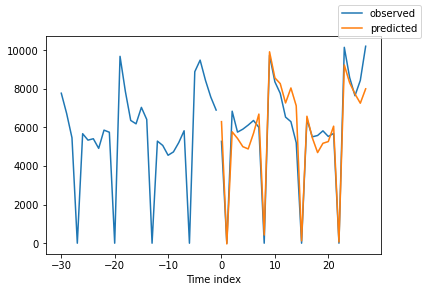

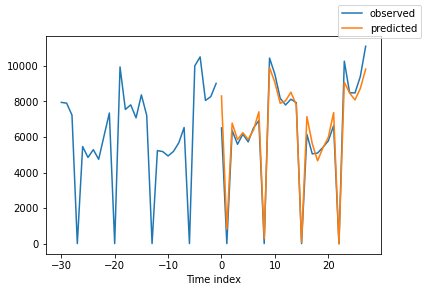

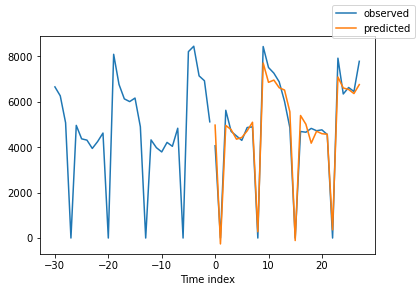

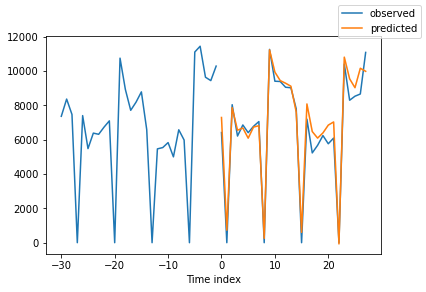

In [13]:
for idx in range(10):  # plot 10 examples
    fig = model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True,
        quantiles_kwargs={'use_metric': False}, prediction_kwargs={'use_metric': False})
    # fig.savefig(os.path.join(save_dir, f"{config['DATASET']}_{config['MODEL']}_{idx}.png"))

### Calculate Contribution Scores

In [14]:
interpret_dict = model._interpret_dict

In [15]:
interpret_dict['1_W'].shape

(1, 2697)

In [16]:
n_samples = interpret_dict['0_merged_context'].shape[0]
n_reals, n_categoricals = interpret_dict['x_reals'], interpret_dict['x_categoricals']
target_size, history_size = config['target_size'], config['history_size']
contrib_encoder = np.empty((target_size, n_samples, config['history_size'], len(n_reals)+len(n_categoricals), 2))
contrib_decoder = np.empty((target_size, n_samples, len(n_reals)+len(n_categoricals), 2))
contrib_encoder.shape, contrib_decoder.shape

((28, 935, 30, 8, 2), (28, 935, 8, 2))

In [17]:
interpret_dict['alpha_out'].shape, interpret_dict['beta_out'].shape

(torch.Size([935, 30, 1]), torch.Size([935, 30, 87]))

In [18]:
interpret_dict['0_W'].shape, interpret_dict['0_b'], interpret_dict['0_merged_context'].shape, interpret_dict['0_output'].shape

((1, 2697),
 Linear(in_features=2697, out_features=1, bias=False),
 (935, 2697),
 (935, 1, 1))

In [19]:
target_size = config['target_size']
cat_emb_sizes = {k: v[1] for k, v in interpret_dict['embedding_sizes'].items()}
input_size = sum(cat_emb_sizes.values()) + len(n_reals)
for target_idx in tqdm(range(target_size)):
    # Encoder inps
    W = interpret_dict[f'{target_idx}_W']
    merged_context = interpret_dict[f'{target_idx}_merged_context']
    for history_idx in range(config['history_size']):
        # Continuous vars
        start_idx = 0 + history_idx * input_size
        for feat_idx, feat in enumerate(interpret_dict['x_reals']):
            end_idx = start_idx + 1
            contrib = merged_context[:, start_idx:end_idx] @ W.T[start_idx:end_idx]
            contrib_encoder[target_idx, :, history_idx, feat_idx, :] = contrib    
            start_idx += 1
        # Categorical vars
        for cat_feat_i, (feat, emb_size) in enumerate(cat_emb_sizes.items()):
            feat_idx = len(n_reals) + cat_feat_i
            end_idx = start_idx + emb_size
            contrib = merged_context[:, start_idx:end_idx] @ W.T[start_idx:end_idx]
            contrib_encoder[target_idx, :, history_idx, feat_idx, :] = contrib    
            start_idx = end_idx
    # Decoder inps
    # Continuous vars
    for feat_idx, feat in enumerate(interpret_dict['x_reals']):
        end_idx = start_idx + 1
        contrib = merged_context[:, start_idx:end_idx] @ W.T[start_idx:end_idx]
        contrib_decoder[target_idx, :, feat_idx, :] = contrib    
        start_idx += 1
    # Categorical vars
    for cat_feat_i, (feat, emb_size) in enumerate(cat_emb_sizes.items()):
        feat_idx = len(n_reals) + cat_feat_i
        end_idx = start_idx + emb_size
        contrib = merged_context[:, start_idx:end_idx] @ W.T[start_idx:end_idx]
        contrib_decoder[target_idx, :, feat_idx, :] = contrib    
        start_idx = end_idx

100%|██████████| 28/28 [00:00<00:00, 284.23it/s]


### Check completeness

In [20]:
interpret_dict['2_output'].shape

(935, 1, 1)

In [21]:
print(interpret_dict['2_output'][5, 0, :])
print(contrib_encoder[2, 5, :, :, :].sum(axis=0).sum(axis=0) + contrib_decoder[2, 5, :, :].sum(axis=0))

[1.0642595]
[1.06425939 1.06425939]


## Visualize contributions

tensor([0, 0, 1, 1, 0, 0]) ['Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']


<Figure size 720x1440 with 0 Axes>

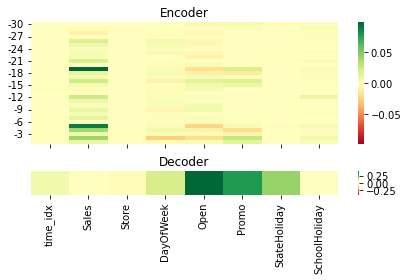

In [23]:
sample_idx = 0
target_idx = 9
# print(x['encoder_cat'][20, :, :], n_categoricals)
print(x['decoder_cat'][sample_idx, target_idx], n_categoricals)
# Mu
plt.figure(figsize=(10,20))
fig, axarr = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [5, 1]})

# axarr[0].set_title(f'Mu encoder Contributions for sample {sample_idx}, target {target_idx} ')
axarr[0].set_title('Encoder')
data = contrib_encoder[target_idx, sample_idx, :, :, 0]
vmin, vmax = -np.abs(data).max(), np.abs(data).max()
sns.heatmap(data, 
            xticklabels=n_reals+n_categoricals,
            yticklabels=range(-history_size, 0),
            ax=axarr[0],
            cmap='RdYlGn',
            vmin=vmin, vmax=vmax,
            )
axarr[0].set_yticks(axarr[0].get_yticks()[::3])
# axarr[1].set_title(f'Mu decoder Contributions for sample {sample_idx}, target {target_idx} ')
axarr[1].set_title('Decoder')
data = contrib_decoder[target_idx, sample_idx, :, 0, np.newaxis].T
vmin, vmax = -np.abs(data).max(), np.abs(data).max()
sns.heatmap(data, 
            xticklabels=n_reals+n_categoricals,
            yticklabels=0,
            ax=axarr[1],
            cmap='RdYlGn',
            vmin=vmin, vmax=vmax,
            )
plt.tight_layout()
# plt.savefig(os.path.join(save_dir, f"{config['DATASET']}_{config['MODEL']}_mu_sample_{sample_idx}_target_{target_idx}.png"))

### Average Contribution

<Figure size 720x1440 with 0 Axes>

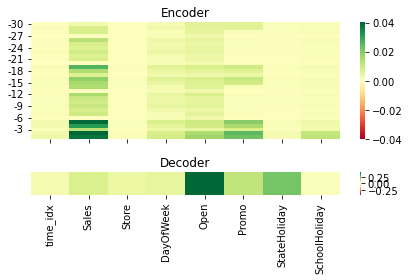

In [24]:
plt.figure(figsize=(10,20))
fig, axarr = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [5, 1]})

# axarr[0].set_title(f'Mu encoder Contributions for sample {sample_idx}, target {target_idx} ')
axarr[0].set_title(f'Encoder')
data = np.abs(contrib_encoder[:, :, :, :, 0]).mean(axis=0).mean(axis=0)
vmin, vmax = -np.abs(data).max(), np.abs(data).max()
sns.heatmap(data, 
            xticklabels=n_reals+n_categoricals,
            yticklabels=range(-history_size, 0),
            ax=axarr[0],
            cmap='RdYlGn',
            vmin=vmin, vmax=vmax,
            )
axarr[0].set_yticks(axarr[0].get_yticks()[::3])
# axarr[1].set_title(f'Mu decoder Contributions for sample {sample_idx}, target {target_idx} ')
axarr[1].set_title(f'Decoder')
data = np.abs(contrib_decoder[:, :, :, 0, np.newaxis]).mean(axis=0).mean(axis=0).T
vmin, vmax = -np.abs(data).max(), np.abs(data).max()
sns.heatmap(data, 
            xticklabels=n_reals+n_categoricals,
            yticklabels=0,
            ax=axarr[1],
            cmap='RdYlGn',
            vmin=vmin, vmax=vmax,
            )
plt.tight_layout()
# plt.savefig(os.path.join(save_dir, f"{config['DATASET']}_{config['MODEL']}_mu_avg.png"))